/opt/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


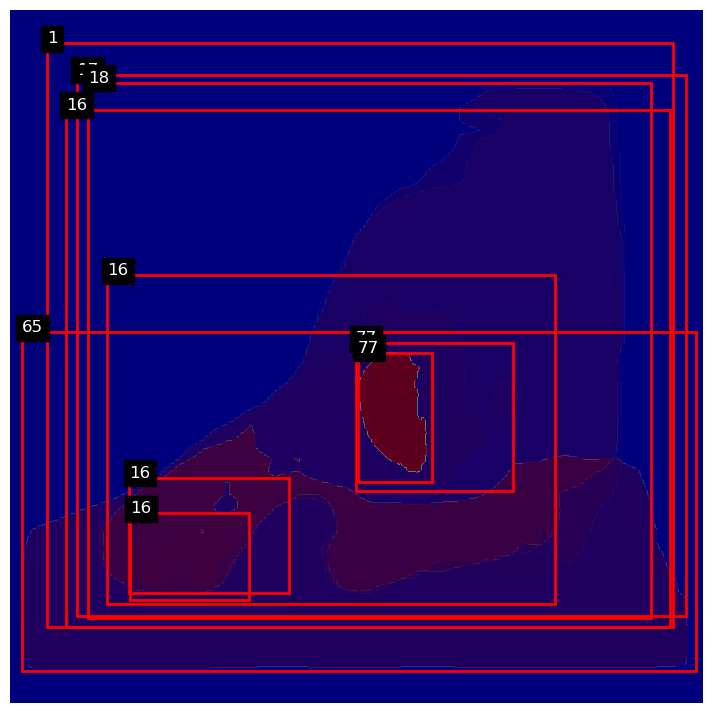

In [36]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


# Load image (ensure it is a grayscale image first)
image_path = '/Users/jiten/Masters/WorkPlace/MRI Fractures Project/test_data_SAGIR/P016 SAGIR_008.jpg'  # Replace with your image path
image = Image.open(image_path).convert("L")  # Convert to grayscale ('L' mode)

# Convert grayscale to RGB by repeating the single channel (3 channels)
image_rgb = image.convert("RGB")  # This repeats the grayscale channel 3 times

# Prepare the image for the model
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_rgb).unsqueeze(0)  # Add batch dimension, shape: [1, C, H, W]

# Perform inference
with torch.no_grad():
    prediction = model(image_tensor)

# Get the masks, boxes, and labels from the output
masks = prediction[0]['masks']  # Shape: [num_objects, H, W]
boxes = prediction[0]['boxes']  # Bounding box coordinates
labels = prediction[0]['labels']  # Object class labels

# Visualize the masks on the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image_rgb)

# Plot each mask
for i in range(masks.shape[0]):
    mask = masks[i, 0] > 0.5  # Apply threshold to get binary mask
    mask = mask.cpu().numpy()
    
    # Display the mask
    ax.imshow(mask, cmap='jet', alpha=0.5)  # Overlay the mask with some transparency

# # Optionally, you can draw bounding boxes and labels
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(x1, y1, str(label.item()), color='white', fontsize=12, backgroundcolor='black')

plt.axis('off')  # Hide axes for better visualization
plt.show()


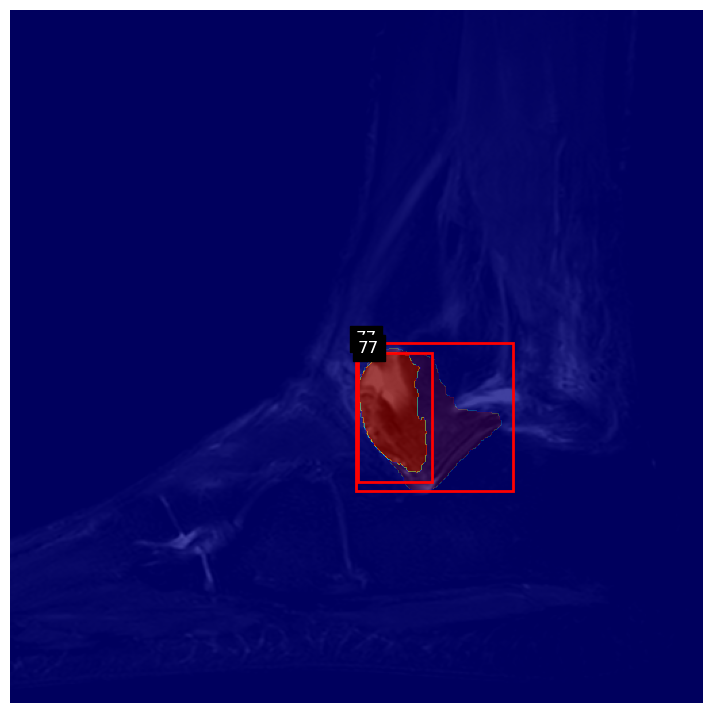

In [35]:
# Visualize the masks on the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image_rgb)

for mask, box, label in zip(masks, boxes, labels):
   if label == 77:
      mask = mask[0] > 0.5
      mask = mask.cpu().numpy()

      # Display the mask
      ax.imshow(mask, cmap='jet', alpha=0.5)  # Overlay the mask with some transparency

   
      x1, y1, x2, y2 = box
      rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
      ax.add_patch(rect)
      ax.text(x1, y1, str(label.item()), color='white', fontsize=12, backgroundcolor='black')

plt.axis('off')  # Hide axes for better visualization
plt.show()    

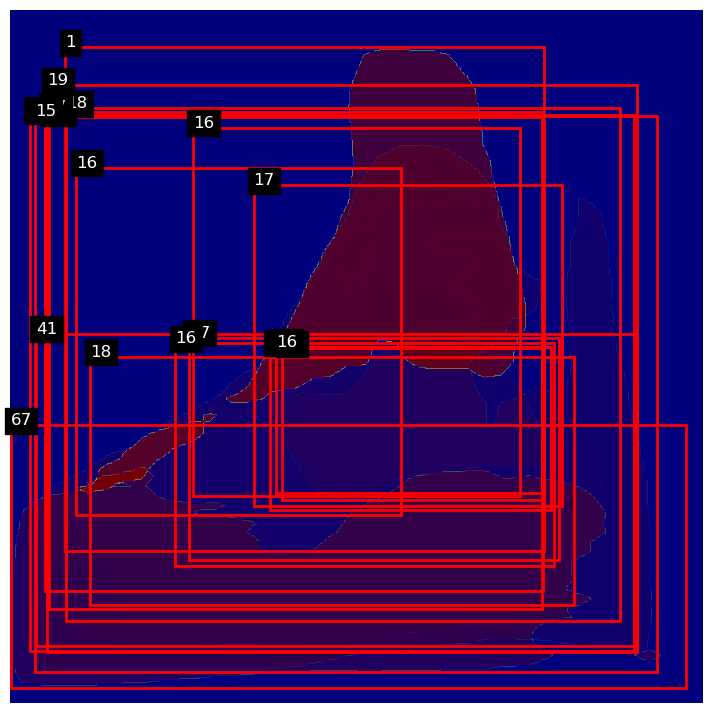

In [44]:
# Load pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


# Load image (ensure it is a grayscale image first)
image_path = '/Users/jiten/Masters/WorkPlace/MRI Fractures Project/test_data_SAGIR/P016 SAGIR_014.jpg'  # Replace with your image path
image = Image.open(image_path).convert("L")  # Convert to grayscale ('L' mode)

# Convert grayscale to RGB by repeating the single channel (3 channels)
image_rgb = image.convert("RGB")  # This repeats the grayscale channel 3 times

# Prepare the image for the model
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_rgb).unsqueeze(0)  # Add batch dimension, shape: [1, C, H, W]

# Perform inference
with torch.no_grad():
    prediction = model(image_tensor)

# Get the masks, boxes, and labels from the output
masks = prediction[0]['masks']  # Shape: [num_objects, H, W]
boxes = prediction[0]['boxes']  # Bounding box coordinates
labels = prediction[0]['labels']  # Object class labels

# Visualize the masks on the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image_rgb)

# Plot each mask
for i in range(masks.shape[0]):
    mask = masks[i, 0] > 0.5  # Apply threshold to get binary mask
    mask = mask.cpu().numpy()
    
    # Display the mask
    ax.imshow(mask, cmap='jet', alpha=0.5)  # Overlay the mask with some transparency

# # Optionally, you can draw bounding boxes and labels
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(x1, y1, str(label.item()), color='white', fontsize=12, backgroundcolor='black')

plt.axis('off')  # Hide axes for better visualization
plt.show()


In [42]:
labels

tensor([17, 18, 16,  2, 18, 17, 19, 16, 18, 16, 16, 17, 17, 41, 16, 15, 67,  1])

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from einops import rearrange
from einops.layers.torch import Rearrange

class PatchEmbedding(nn.Module):
    """
    Converts image patches into embeddings.
    """
    def __init__(self, in_channels=1, embed_dim=96, patch_size=4):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        x = self.projection(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x

class SwinTransformerBlock(nn.Module):
    """
    A single Swin Transformer block with window-based self-attention.
    """
    def __init__(self, dim, num_heads, window_size=7, shift_size=0):
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
        )
    
    def forward(self, x):
        b, n, c = x.shape
        if self.shift_size > 0:
            x = rearrange(x, 'b (h w) c -> b h w c', h=int(n**0.5))
            x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            x = rearrange(x, 'b h w c -> b (h w) c')
        
        shortcut = x
        x = self.norm1(x)
        x, _ = self.attention(x, x, x)
        x = shortcut + x

        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = shortcut + x
        return x

class BasicLayer(nn.Module):
    """
    A Swin Transformer layer with multiple blocks.
    """
    def __init__(self, dim, depth, num_heads, window_size=7):
        super(BasicLayer, self).__init__()
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim, num_heads, window_size, shift_size=(i % 2) * window_size // 2)
            for i in range(depth)
        ])
    
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

class PatchMerging(nn.Module):

    def __init__(self, dim):
        super(PatchMerging, self).__init__()
        self.reduction = nn.Linear(4 * dim, 2 * dim)
        self.norm = nn.LayerNorm(4 * dim)
        
    def forward(self, x, h, w):
        b, n, c = x.shape
        assert n == h * w, f"Number of patches ({n}) must match h*w ({h}*{w})."
        x = rearrange(x, 'b (h w) c -> b h w c', h=h, w=w)
        x0 = x[:, ::2, ::2, :]
        x1 = x[:, 1::2, ::2, :]
        x2 = x[:, ::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], dim=-1)
        x = rearrange(x, 'b h w c -> b (h w) c')
        x = self.norm(x)
        x = self.reduction(x)
        return x, h // 2, w // 2

class SwinUNet(nn.Module):
    """
    Swin-UNet model combining Swin Transformer layers with U-Net's structure.
    """
    def __init__(self, in_channels=1, num_classes=1, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], window_size=7):
        super(SwinUNet, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, embed_dim)
        self.pos_drop = nn.Dropout(0.1)
        
        # Encoder
        self.layers = nn.ModuleList()
        dims = [embed_dim * (2**i) for i in range(len(depths))]
        for i, (dim, depth, heads) in enumerate(zip(dims, depths, num_heads)):
            layer = BasicLayer(dim, depth, heads, window_size)
            self.layers.append(layer)
            if i < len(depths) - 1:
                self.layers.append(PatchMerging(dim))
        
        # Decoder (Upsampling)
        self.decoders = nn.ModuleList()
        for i in range(len(depths) - 1, 0, -1):
            dim = dims[i]
            self.decoders.append(nn.ConvTranspose2d(dim, dims[i - 1], kernel_size=2, stride=2))
        
        # Final Prediction Head
        self.final_conv = nn.Conv2d(dims[0], num_classes, kernel_size=1)
    
    def forward(self, x):
        h, w = x.size(2), x.size(3)
        x, h, w = self.patch_embed(x)  # Patch Embedding
        x = self.pos_drop(x)

        # Encoder
        skips = []
        for layer in self.layers:
            if isinstance(layer, PatchMerging):
                x, h, w = layer(x, h, w)
            else:
                skips.append((x, h, w))
                x = layer(x)

        # Decoder
        for i, decoder in enumerate(self.decoders):
            skip_x, skip_h, skip_w = skips.pop()
            x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
            x = decoder(x)
            x = rearrange(x, 'b c h w -> b (h w) c')
            h, w = skip_h, skip_w
            x = x + skip_x  # Skip connection

        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.final_conv(x)
        return x


In [49]:
model = SwinUNet(in_channels=1, num_classes=1)
input_tensor = torch.randn(1, 1, 224, 224)  # Batch size of 1, grayscale image of 224x224
output = model(input_tensor)
print(output.shape)  # Should output (1, 1, 224, 224)

TypeError: PatchMerging.__init__() takes 1 positional argument but 2 were given